In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.family':'Times New Roman', 
    'font.size': 14,  # 字体大小
    'axes.titlesize': 16,  # 轴标题的字体大小
    'axes.labelsize': 14,  # 轴标签的字体大小
    'xtick.labelsize': 12,  # x轴刻度的字体大小
    'ytick.labelsize': 12,  # y轴刻度的字体大小
    'legend.fontsize': 14,  # 图例的字体大小
})

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split 

# 1.Input

In [2]:
step = 72
dataset = np.load(f'dataset/dataset_{step}.npy')

In [3]:
train , test = train_test_split(
    dataset, random_state = 12, 
    shuffle=True,test_size =0.2
    )

test , validate = train_test_split(
    test, 
    random_state = 72, 
    shuffle=True, 
    test_size =0.5
    )

train.shape, validate.shape, test.shape

((1092, 288), (137, 288), (136, 288))

# 2.Load Model

In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [5]:
class ConvolutionalAutoencoder(nn.Module):
    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, stride=1, padding=3), nn.ReLU(),

            nn.MaxPool1d(kernel_size=2, stride=2), nn.ReLU(),
            nn.Dropout(0.1),

            nn.Conv1d(16, 32, kernel_size=7, stride=1, padding=3), nn.ReLU(),

            nn.MaxPool1d(kernel_size=2, stride=2), nn.ReLU(),
            nn.Dropout(0.1),

            nn.Conv1d(32, 4, kernel_size=1, stride=1, padding=0),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(4, 32, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),

            nn.ConvTranspose1d(32, 32, kernel_size=2, stride=2, padding=0),  # 上采样
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.ConvTranspose1d(32, 16, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),

            nn.ConvTranspose1d(16, 16, kernel_size=2, stride=2, padding=0),  # 上采样
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.ConvTranspose1d(16, 1, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
model = ConvolutionalAutoencoder().to(device)
model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

# 3.Predic

In [7]:
test_dataset = torch.tensor(test).unsqueeze(-1).permute(0, 2, 1).to(device)
model.eval()
with torch.no_grad():
    prediction = model(test_dataset.float())

pre_np = prediction.numpy().squeeze()

# 3.Performance Evaluation

C:\Users\Fashion_Wang\AppData\Local\Temp\ipykernel_5564\3870606578.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mse, shade=True, color='orange')
d:\conda_envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


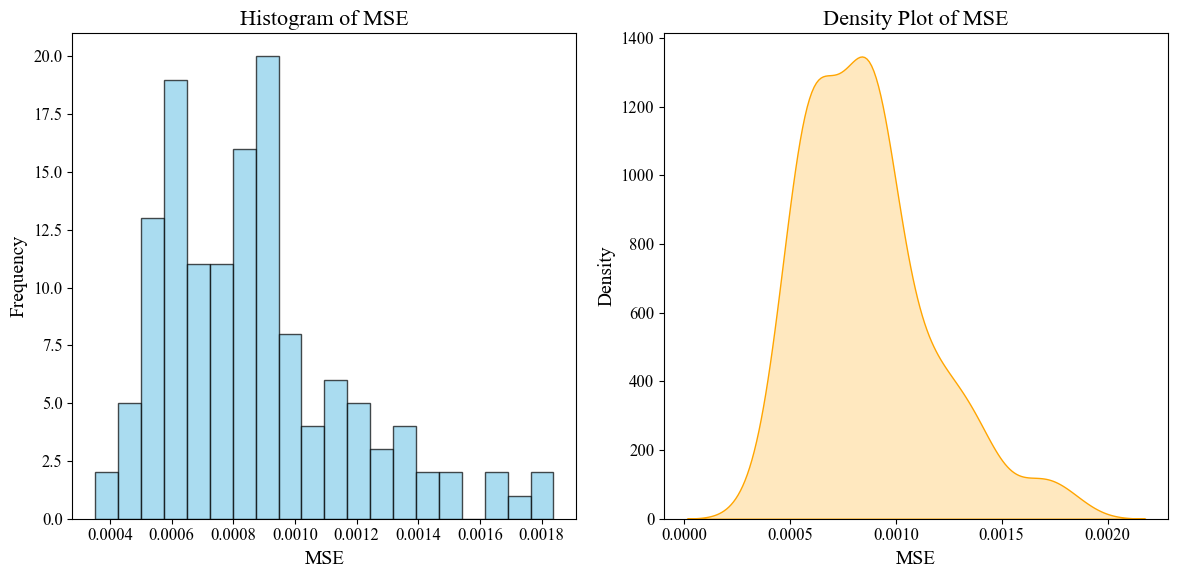

In [8]:
mse = np.mean((pre_np - test) ** 2, axis=1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(mse, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogram of MSE")
plt.xlabel("MSE")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.kdeplot(mse, shade=True, color='orange')
plt.title("Density Plot of MSE")
plt.xlabel("MSE")

plt.tight_layout()
plt.show()

# 4.Anomaly Detection

limit

In [9]:
def get_tolerance(data):
    dataset = torch.tensor(data).unsqueeze(-1).permute(0, 2, 1).to(device)
    model.eval()
    with torch.no_grad():
        prediction = model(dataset.float())

    pre_np = prediction.numpy().squeeze()
    error = (data - pre_np)**2
    return error

error_limit = np.mean(get_tolerance(validate)) + np.std(get_tolerance(validate))
error_limit

0.00407699809184345

In [10]:
np.std(get_tolerance(validate))

0.003191629986952341

In [11]:
np.mean(get_tolerance(validate))

0.000885368104891108

number of anomaly point

In [12]:
counts = np.sum(((pre_np - test) ** 2)> error_limit, axis=1)
non_zero_counts = counts[(counts != 0) & (counts != 1)]

C:\Users\Fashion_Wang\AppData\Local\Temp\ipykernel_5564\1599432753.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(non_zero_counts, shade=True, color='orange')
d:\conda_envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


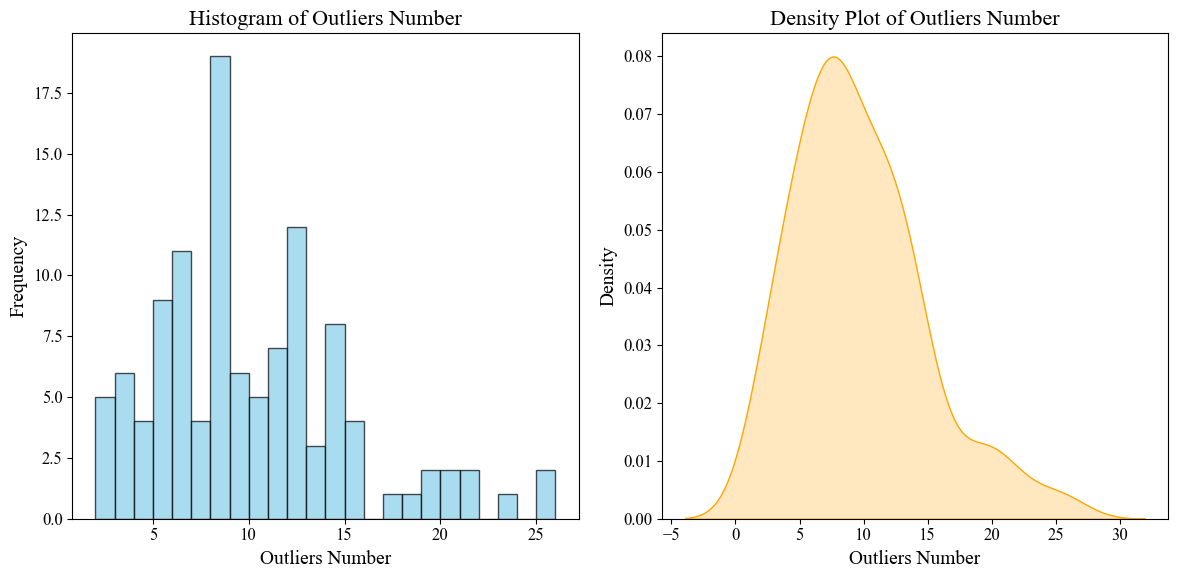

In [13]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(non_zero_counts, bins=24, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Outliers Number")
plt.xlabel("Outliers Number")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.kdeplot(non_zero_counts, shade=True, color='orange')
plt.title("Density Plot of Outliers Number")
plt.xlabel("Outliers Number")

plt.tight_layout()
plt.show()

In [14]:
np.mean(non_zero_counts)

9.649122807017545

In [15]:
def plot_error(num, error_limit):
    ts1 = test[num]
    ts2 = pre_np[num]
    error = (ts1 - ts2)**2

    # 创建图形和子图
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # 绘制第一个子图
    axs[0].plot(ts1, label='Input')
    axs[0].plot(ts2, label='Output', linestyle='--')
    axs[0].set_title('Input and output comparison')
    
    # 标记误差超过许用误差的点
    over_tolerance = np.abs(error) > error_limit
    axs[0].scatter(np.where(over_tolerance), ts1[over_tolerance], color='red', label='Out of Tolerance (anormaly)')
    # axs[0].scatter(np.where(over_tolerance), ts2[over_tolerance], color='yellow', label='Out of Tolerance (TS2)')
    axs[0].legend(loc='upper right')

    # 绘制第二个子图
    axs[1].plot(error, color='red', label='Squared Error')
    axs[1].set_title('Reconstruction error')
    axs[1].axhline(y=error_limit, color='green', linestyle='--', label='Tolerance Threshold')
    axs[1].set_xlabel('Time Step')
    axs[1].set_ylabel('Squared Error')
    axs[1].legend(loc='upper right')

    # 显示整个图形
    plt.tight_layout()
    plt.show()

点异常

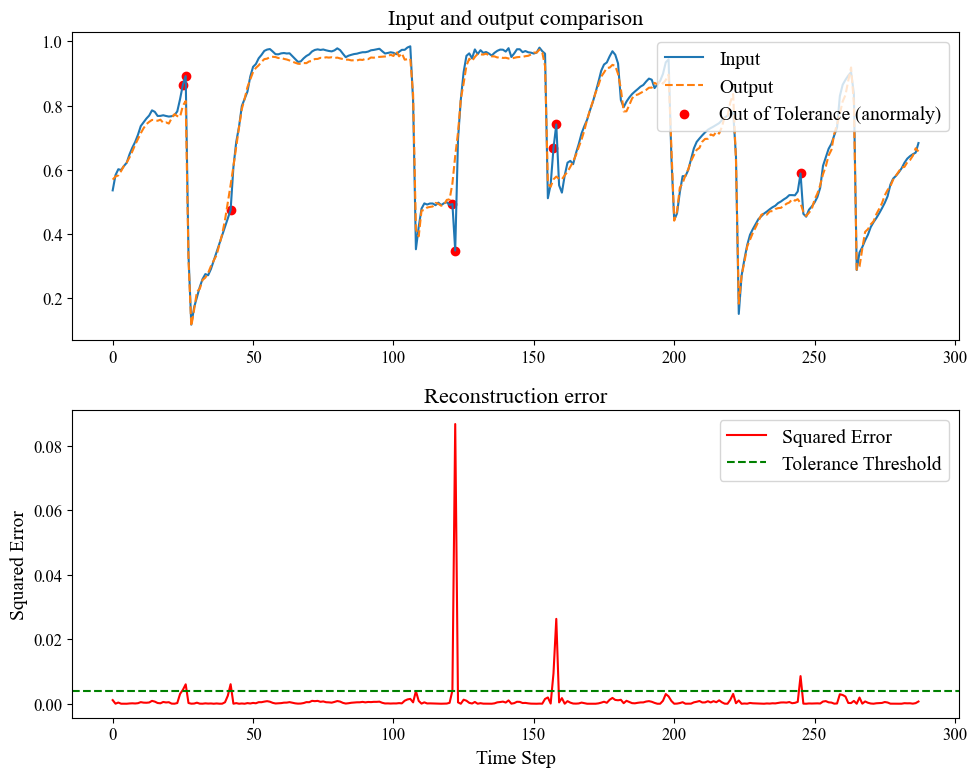

In [17]:
plot_error(12, error_limit)

子序列异常

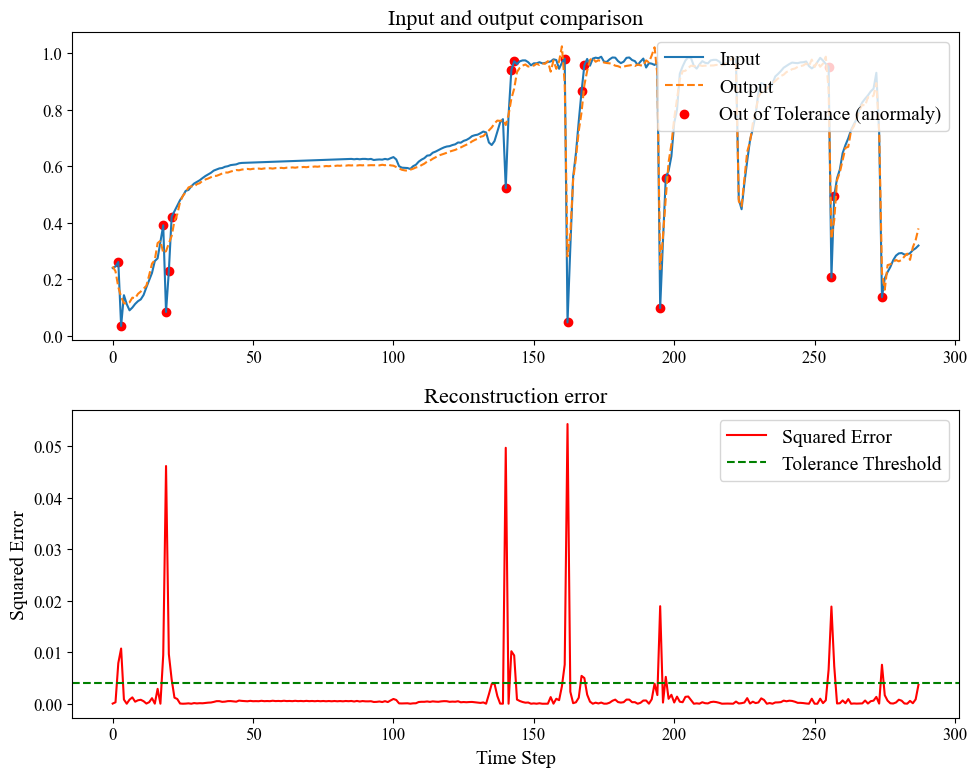

In [21]:
plot_error(2, error_limit)

整个序列异常

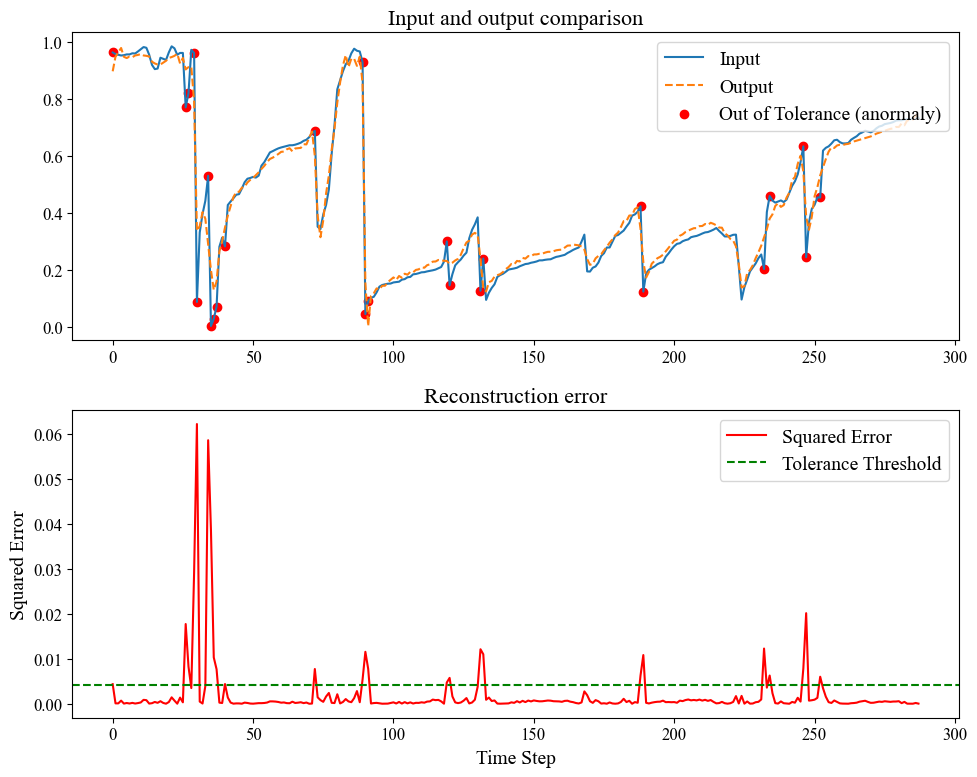

In [20]:
plot_error(19, error_limit)

上升阶段的误识别

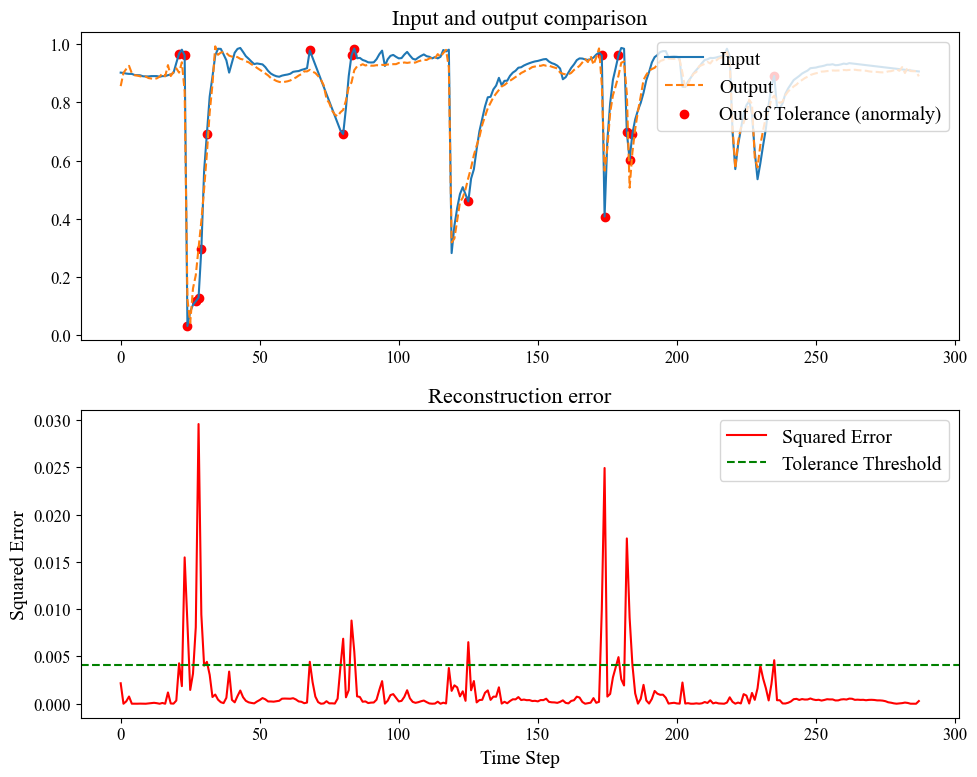

In [22]:
plot_error(25, error_limit)